# Intuit / Quicken Quickbooks Group Assignment
Class: Marketing Analytics (EWMBA263 -1)
Team: Albert Deng, Peter Pang, Alex Im, and DJ Prahladka

## 0. Data Initialization

Import data and look at the variables available

In [1]:
import pandas
import shared.mba263 as mba263
import matplotlib.pyplot as plt
import numpy as np

data = pandas.read_csv('shared/intuit.csv')
data.head(10)

c:\Users\alber\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,id,sex,bizflag,zip,zip_bins,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1
0,1,U,1,99999,20,1,129.5,11,1,0,0,0,0
1,2,U,1,99999,20,2,65.0,4,14,0,0,0,0
2,3,U,1,99999,20,1,24.5,13,36,1,0,0,0
3,4,U,1,99999,20,1,80.5,5,19,1,0,0,0
4,5,U,1,99999,20,1,111.0,14,7,0,0,0,0
5,6,U,1,99999,20,1,61.5,14,20,0,0,1,0
6,7,U,1,99999,20,1,56.0,5,27,0,0,1,0
7,8,U,1,99999,20,1,39.5,4,2,0,0,0,0
8,9,U,1,99999,20,1,22.0,17,1,0,0,0,1
9,10,U,1,99999,20,2,113.0,7,15,0,0,0,0


In [2]:
data.describe()

,id,bizflag,zip,zip_bins,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1
count,20000.000000,20000.000000,20000.0000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,0.244400,54350.2613,10.499000,2.079450,93.581000,15.779650,15.751400,0.208250,0.027100,0.215600,0.048050
std,5773.647028,0.429742,32776.4059,5.766755,1.246361,82.601398,9.527331,10.020435,0.406067,0.162379,0.411248,0.213877
min,1.000000,0.000000,0.0000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,5000.750000,0.000000,23451.0000,5.000000,1.000000,37.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,10000.500000,0.000000,55402.5000,10.500000,2.000000,71.000000,15.000000,15.000000,0.000000,0.000000,0.000000,0.000000
75%,15000.250000,0.000000,89018.7500,15.250000,3.000000,124.500000,24.000000,24.000000,0.000000,0.000000,0.000000,0.000000
max,20000.000000,1.000000,99999.0000,20.000000,5.000000,937.500000,36.000000,36.000000,1.000000,1.000000,1.000000,1.000000


Add additional variables and define scope for evaluation

In [3]:
# Add transformational ordinal and indicator variables
data = pandas.get_dummies(data, columns=['sex'])

# Define scope for columns
variables = ['sex_B', 'sex_F', 'sex_M', 'sex_U', 'bizflag','zip_bins',
                               'numords','dollars','last','sincepurch','version1','owntaxprod','upgraded']

## 1. Run analyses
### a) Conduct RFM Analysis
Conduct both a sequential and independent RFM analysis, adding predictions on both. Begin by constructing deciles and RFM columns.

In [4]:
# Define deciles for RFM
data['r_decile'] = mba263.ntile(data['last'], 10)
data['f_decile'] = mba263.ntile(data['numords'], 10)
data['m_decile'] = mba263.ntile(data['dollars'], 10)

# Reverse frequency and monetary deciles where we want higher first
data['f_decile'] = 9 - data['f_decile']
data['m_decile'] = 9 - data['m_decile']

# Construct RFM scores
# Start with independent RFM score
data['rfm_independent'] = data['r_decile'] * 100 + data['f_decile'] * 10 + data['m_decile']

# Construct sequential RFM score
data['rfm_sequential'] = mba263.rfm_sq(data[['dollars', 'numords', 'last']], 10)

Generate predictions based on RFM score, where the RFM response rate is higher than the breakeven response rate

In [5]:
# Calculate the breakeven response rate
per_person_mail_cost = 1.41 # assumption from supporting doc
per_person_profit = 60 # assumption from supporting doc

# These numbers assume breakeven rate is halved
breakeven_rate = per_person_mail_cost / per_person_profit
print("Breakeven Rate: {:.2%}".format(breakeven_rate))

# Iterate over all the RFM values and assign a variable if RFM indicates it exceeds breakeven
data["rfm_i_send"] = 0
data["rfm_s_send"] = 0

# Iterate over every single group
for i in range(1000):
    subset_rfm_i = data.loc[data["rfm_independent"] == i]
    subset_rfm_s = data.loc[data["rfm_sequential"] == i]

    # Calculate the response rate for each group
    data.loc[data["rfm_independent"] == i, "p_rfmi"] = subset_rfm_i["res1"].mean()
    data.loc[data["rfm_sequential"] == i, "p_rfms"] = subset_rfm_s["res1"].mean()

Breakeven Rate: 2.35%


### b) Run ML Models
Create a helper function to run all the models on a given dataset

In [6]:
### A function to run a logistic regression, a logistic regression w/ regularization, 
### a neural network, and a random forest
def run_ml_models(dataset, predict, variables):
    df = dataset.copy()

    # Use a simple logistic regression
    result_logit = mba263.logit(df[predict], df[variables])
    df['p_log']=result_logit.predict()

    # Use a logistic regression with regularization
    result_logit_reg = mba263.logit_reg(df[predict], df[variables])
    df['p_logr'] = result_logit_reg.predict()

    # Use a neural network
    result_nn = mba263.neural_network(df[predict],df[variables])
    df['p_nn'] = result_nn.predict(df[variables])

    # Use a random forest
    result_rf = mba263.random_forest(df[predict],df[variables])
    df['p_rf'] = result_rf.predict(df[variables])

    return df[['id', 'p_log','p_logr','p_nn','p_rf', 'p_rfmi', 'p_rfms','res1']]

TODO: Implement cross validation on datasets

Run the ML models

In [7]:
# Create predictions
predictions = run_ml_models(data, "res1", variables)
styled_predictions = predictions.head(20).style.format({
    'p_log': '{:.2%}',
    'p_logr': '{:.2%}',
    'p_nn': '{:.2%}',
    'p_rf': '{:.2%}',
    'p_rfmi': '{:.2%}',
    'p_rfms': '{:.2%}',
})
styled_predictions

Optimization terminated successfully.
         Current function value: 0.178707
         Iterations 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.17870659963577418
            Iterations: 76
            Function evaluations: 82
            Gradient evaluations: 76


,id,p_log,p_logr,p_nn,p_rf,p_rfmi,p_rfms,res1
0,1,1.41%,1.41%,2.39%,2.95%,0.00%,4.17%,0
1,2,2.48%,2.48%,5.25%,3.78%,9.09%,9.09%,0
2,3,2.70%,2.70%,2.50%,3.91%,3.12%,3.12%,0
3,4,3.74%,3.74%,4.20%,6.48%,4.35%,4.00%,0
4,5,1.25%,1.25%,2.16%,2.64%,0.00%,0.00%,0
5,6,2.72%,2.72%,4.25%,3.95%,5.56%,3.97%,0
6,7,4.38%,4.38%,5.29%,6.85%,5.33%,5.10%,0
7,8,1.83%,1.83%,3.10%,3.78%,7.14%,5.17%,0
8,9,0.94%,0.94%,1.45%,2.40%,4.32%,3.85%,1
9,10,2.27%,2.27%,4.89%,3.75%,3.03%,3.03%,0


## 2. Evaluation
### a) Evaluate accuracy and gains

In [8]:
from sklearn.metrics import roc_auc_score

### A function to calculate the AUC from a ROC curve
def calculate_auc(predictions):
    auc_rfm_i = roc_auc_score(predictions['res1'], predictions['p_rfmi'])
    auc_rfm_s = roc_auc_score(predictions['res1'], predictions['p_rfms'])
    auc_log = roc_auc_score(predictions['res1'], predictions['p_log'])
    auc_logr = roc_auc_score(predictions['res1'], predictions['p_logr'])
    auc_nn = roc_auc_score(predictions['res1'], predictions['p_nn'])
    auc_rf = roc_auc_score(predictions['res1'], predictions['p_rf'])

    return pandas.DataFrame({'rfm_i':auc_rfm_i, 
                             'rfm_s':auc_rfm_s, 
                             'logistic':auc_log, 
                             'logistic_reg':auc_logr, 
                             'neural_net':auc_nn, 
                             'random_forest':auc_rf}, index=[0])

Evaluate each model's performance with the ROC curve

In [9]:
# Calculate ROC AUC - this will be used to compare effectiveness after cross-validation
roc_auc = calculate_auc(predictions)
roc_auc = roc_auc.style.format("{:.2%}")
roc_auc

,logistic,logistic_reg,neural_net,random_forest,rfm_i,rfm_s
0,70.81%,70.81%,76.62%,76.51%,74.79%,73.95%


### b) Evaluate gains

In [10]:
### A function to calculate the gains from a model
def evaluate_predictions(predictions):
    gains_rfm_i = mba263.gain(predictions['res1'], predictions['p_rfmi'],bins=30)
    gains_rfm_s = mba263.gain(predictions['res1'], predictions['p_rfms'],bins=30)
    gains_l = mba263.gain(predictions['res1'], predictions['p_log'],bins=30)
    gains_lr = mba263.gain(predictions['res1'], predictions['p_logr'],bins=30)
    gains_nn = mba263.gain(predictions['res1'], predictions['p_nn'],bins=30)
    gains_rf = mba263.gain(predictions['res1'], predictions['p_rf'],bins=30)

    return pandas.DataFrame({'rfm_i':gains_rfm_i, 
                             'rfm_s':gains_rfm_s, 
                             'logistic':gains_l, 
                             'logistic_reg':gains_lr, 
                             'neural_net':gains_nn, 
                             'random_forest':gains_rf})

### A function to construct a gains chart
def plot_gains(gains):
    plt.plot(gains['rfm_i'], label='RFM Independent', color='lightblue')
    plt.plot(gains['rfm_s'], label='RFM Sequential', color='blue')
    plt.plot(gains['logistic'], label='Logistic Regression', color='pink')
    plt.plot(gains['logistic_reg'], label='Logistic Regression w/ Regularization', color='red')
    plt.plot(gains['neural_net'], label='Neural Network', color='lightgreen')
    plt.plot(gains['random_forest'], label='Random Forest', color='green')
    plt.plot([0, 30], [0, 1], 'k--', label='Random')
    plt.xlabel('Decile')
    plt.ylabel('Cumulative Gain')
    plt.title('Gains Chart')
    plt.legend()
    plt.show()

### A function to calculate the AUC from the gains curves
def calculate_gains_auc(predictions):
    gains_rfm_i_auc = np.trapz(predictions['rfm_i'], dx=1/30)
    gains_rfm_s_auc = np.trapz(predictions['rfm_s'], dx=1/30)
    gains_l_auc = np.trapz(predictions['logistic'], dx=1/30)
    gains_lr_auc = np.trapz(predictions['logistic_reg'], dx=1/30)
    gains_nn_auc = np.trapz(predictions['neural_net'], dx=1/30)
    gains_rf_auc = np.trapz(predictions['random_forest'], dx=1/30)

    return pandas.DataFrame({'rfm_i':gains_rfm_i_auc, 
                             'rfm_s':gains_rfm_s_auc, 
                             'logistic':gains_l_auc, 
                             'logistic_reg':gains_lr_auc, 
                             'neural_net':gains_nn_auc, 
                             'random_forest':gains_rf_auc}, index=[0])

Calculate and compare gains for each model

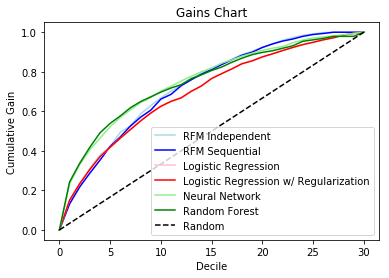

,logistic,logistic_reg,neural_net,random_forest,rfm_i,rfm_s
0,69.76%,69.77%,75.24%,74.85%,73.18%,72.48%


In [11]:
gains = evaluate_predictions(predictions)
gains_auc = calculate_gains_auc(gains)
gains_auc = gains_auc.style.format("{:.2%}")

plot_gains(gains)
gains_auc

### c) Evaluate expected profits

In [12]:
### A function to calculate the expected profit based on a set of predictions
### by 1) removing those who have already responded, 2) identifying those whose 
### predicted probability exceeds the threshold rate, 3) halving the predicted
### response rate, 4) calculating expected profit, and 5) subtracting the mail cost
def calculate_exp_profit(predictions, field, population_size, threshold=breakeven_rate):
    # Remove people who have already responded
    second_wave_subset = predictions.loc[predictions['res1'] == 0]

    # Calculate the percent of people to target
    target_audience = second_wave_subset[second_wave_subset[field] > threshold]
    scaling_factor = population_size / len(second_wave_subset) # will use to scale up results

    # Calculate expected profit based on the predicted response rate (halved) times per-person profit
    # Predicted response rate is halved based on assumption in the case
    gross_profit = scaling_factor * (target_audience[field] / 2 * per_person_profit).sum()
    mail_cost = scaling_factor * len(target_audience) * per_person_mail_cost

    return [field, gross_profit - mail_cost, len(target_audience), len(second_wave_subset), 
            scaling_factor * len(target_audience), scaling_factor * len(second_wave_subset)]

### Calculate the expected profits across all the predictions
def evaluate_profits(predictions, population_size, threshold=breakeven_rate):
    exp_rfmi = calculate_exp_profit(predictions, 'p_rfmi', population_size, threshold)
    exp_rfms = calculate_exp_profit(predictions, 'p_rfms', population_size, threshold)
    exp_log = calculate_exp_profit(predictions, 'p_log', population_size, threshold)
    exp_logr = calculate_exp_profit(predictions, 'p_logr', population_size, threshold)
    exp_nn = calculate_exp_profit(predictions, 'p_nn', population_size, threshold)
    exp_rf = calculate_exp_profit(predictions, 'p_rf', population_size, threshold)

    transposed = [exp_rfmi, exp_rfms, exp_log, exp_logr, exp_nn, exp_rf]

    return pandas.DataFrame(transposed, columns=['Model', 'Expected Profit', 'Targeted People', 
                                                 'Eligible Sample', 'Targeted Population', 'Total Population'])

Evaluate the models and determine the expected profitability for each model

In [13]:
# Run evaluation on datasets
total_population = 801821
wave_1_responders = 38487
mailing_population = total_population - wave_1_responders

exp_profits = evaluate_profits(predictions, mailing_population, breakeven_rate)
exp_profits = exp_profits.style.format({'Expected Profit': '${:,.2f}',
                                        'Targeted People': '{:,.0f}',
                                        'Eligible Sample': '{:,.0f}',
                                        'Targeted Population': '{:,.0f}',
                                        'Total Population': '{:,.0f}'})
exp_profits

,Model,Expected Profit,Targeted People,Eligible Sample,Targeted Population,Total Population
0,p_rfmi,"$241,133.77","13,306","19,039","533,480","763,334"
1,p_rfms,"$248,429.39","13,094","19,039","524,980","763,334"
2,p_log,"$204,538.50","13,233","19,039","530,553","763,334"
3,p_logr,"$204,477.07","13,234","19,039","530,593","763,334"
4,p_nn,"$232,787.87","11,432","19,039","458,345","763,334"
5,p_rf,"$-48,898.13","19,039","19,039","763,334","763,334"


### WARNING: THIS IS LEGACY CODE, PLEASE IGNORE

In [ ]:
# Predicted response rate is half the first response rate
data['p_res2']=data['res1']/2

# Determine target customers for mailing
breakeven = 0.0235
data['second_mail'] = 1*(data['p_res2']>=breakeven)&(data['res1']==0)

# Calculate the number of customers to mail
len_second_mail = len(data[data['second_mail']==1])

# Calculate the profits from the mailing
mail_cost = 1.41
profit_per_customer = 60
profit_second_mail = (profit_per_customer*data[(data['second_mail'] == 1)]['p_res2'].mean()*len_second_mail)-(mail_cost*len_second_mail)
print(profit_second_mail)

: 